<a href="https://colab.research.google.com/github/09tangriro/InSight-FYP/blob/master/ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

This notebook covers the different machine learning strategies employed to detect donks from the NASA InSight mission on Mars. A Google Collab is used to take advantage of the inbuilt graphics card capabilities for neural network training. Go to Runtime->Change runtime type and make sure Hardware Acceleration is set to GPU.

In [0]:
!pip install hmmlearn
import seaborn as sns
import warnings
warnings.filterwarnings(action='once')
from multiprocessing import Pool
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import random
from scipy import signal
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.svm import SVC, SVR
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from hmmlearn import hmm

First, we load the relevant data saved in the FYPData folder. In the load function, simply pass through the file directory. In this case, preprocessing handles data from different sols separately, so these must also be combined here into one data structure. 

In [0]:
'/content/drive/My Drive/FYP/FYPdata/Feature Set CNN Multivariate.npy'
'/content/drive/My Drive/FYP/FYPdata/Target CNN Multivariate.npy'
'/content/drive/My Drive/FYP/FYPdata/Feature Set CNN Multivariate 194.npy'
'/content/drive/My Drive/FYP/FYPdata/Target CNN Multivariate 194.npy'
'/content/drive/My Drive/FYP/FYPdata/Feature Set CNN Multivariate 195.npy'
'/content/drive/My Drive/FYP/FYPdata/Target CNN Multivariate 195.npy'
def load(paths):
  res = [None]*len(paths)
  np_load_old = np.load

  # modify the default parameters of np.load
  np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

  # call load_data with allow_pickle implicitly set to true
  for i,path in enumerate(paths):
    try:
      res[i] = np.load(path)
    except:
      np.load = np_load_old

  # restore np.load for future normal usage
  np.load = np_load_old
  res = np.concatenate(tuple(res))
  return res




To improve feature separation, the data is standardized, since the distribution of the data follows a Gaussian pattern. This is different from normalization where features are scaled between 0 and 1; here the mean is set to 0 and the standard deviation is set to 1. Furthermore, the set is shuffled for better sets when it comes to cross validation later on.

In [0]:
def scaling(feature_data,target_data,shape=None,scale_features=False,scale_samples=False,one_hot=False):
  if scale_samples == True:
    f = [None]*len(feature_data)
    for i,s in enumerate(feature_data):
      z = preprocessing.scale(s[0].flatten())
      n = preprocessing.scale(s[1].flatten())
      e = preprocessing.scale(s[2].flatten())
      f[i] = np.concatenate((z,n,e))
    f = np.array(f)
    x = f.reshape(shape)
  else:
    x = feature_data.reshape(shape)
  if scale_features == True:
    x = preprocessing.scale(x)
  y = target_data
  if one_hot == True:
    y = to_categorical(target_data)
  x,y = shuffle(x,y)
  return x,y

Cross validation is done to get a more reliable indication of model performance with respect to the data. 10 folds are used as a standard balance between the variance and bias tradeoff. 

In [0]:
def get_false(predicted,target,x):
  res = []
  for i,s in enumerate(predicted):
    if s != target[i]:
      res.append(x[i])
  return np.array(res)

def cross_validate_sklearn(k,x,y,model,serial=True):
  scores = []
  precision = []
  recall = []
  false = []
  conf_matrix = np.zeros(shape=(2,2))
  kf = StratifiedKFold(n_splits=k)
  for train, test in kf.split(x,y):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    model = model.fit(x_train,y_train)
    predicted = model.predict(x_test)
    acc = np.mean(predicted == y_test)
    false.append(get_false(predicted,y_test,x_test))
    conf_matrix += confusion_matrix(y_test,predicted)
    precision.append(precision_score(y_test,predicted,average='binary'))
    recall.append(recall_score(y_test,predicted,average='binary'))
    scores.append(acc)
  return np.mean(scores),np.mean(precision),np.mean(recall),np.std(scores),conf_matrix, np.array(false)

In [0]:
def train(k,x,y,model):
  scores = []
  precision = []
  recall = []
  false = []
  conf_matrix = np.zeros(shape=(2,2))
  models = [model]*3
  predicted = [None]*3
  kf = StratifiedKFold(n_splits=k)
  for train, test in kf.split(x,y):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    if len(x_train.shape) > 3:
      x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2]*x_train.shape[3])
      x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2]*x_test.shape[3])
    for i in range(3):
      models[i].fit(x_train[:,i,:],y_train)
      predicted[i] = models[i].predict_proba(x_test[:,i,:])
    z = np.mean(predicted,axis=0)
    z = [np.where(z[i] == np.amax(z[i]))[0][0] for i in range(len(z))]
    acc = np.mean(z == y_test)
    false.append(get_false(z,y_test,x_test))
    conf_matrix += confusion_matrix(y_test,z)
    precision.append(precision_score(y_test,z,average='binary'))
    recall.append(recall_score(y_test,z,average='binary'))
    scores.append(acc)
  return np.mean(scores),np.mean(precision),np.mean(recall),np.std(scores),conf_matrix, np.array(false)

(151, 3, 1501)


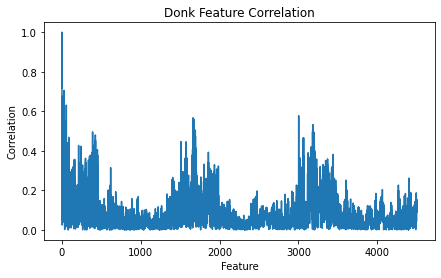

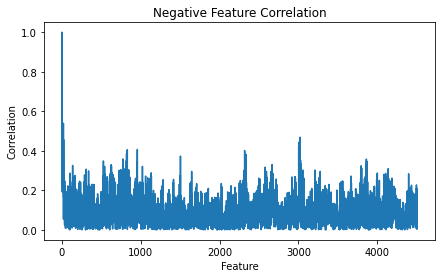

[   0    0    0 ... 4502 4502 4502]


In [0]:
donk = filter(feature_data,target_data,1)#.reshape(151,1503)
neg = filter(feature_data,target_data,0)#.reshape(151,1503)
print(neg.shape)

def normalize(donk):
  for i,s in enumerate(donk):
    for j,ax in enumerate(s):
      donk[i][j] -= np.mean(donk[i][j])
  return donk

donk = normalize(donk)
neg = normalize(neg)

x = neg.reshape(151,4503)
y = donk.reshape(151,4503)

cm = abs(np.corrcoef(y.T))
cm1 = abs(np.corrcoef(x.T))
plt.rcParams["figure.figsize"] = (7,4)

plt.plot(cm[1])
plt.title('Donk Feature Correlation')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.savefig('donk_corr.pdf',format='pdf')
plt.show()

plt.plot(cm1[1])
plt.title('Negative Feature Correlation')
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.savefig('neg_corr.pdf',format='pdf')
plt.show()

high_corrs = np.where(cm > 0.5)[0]
print(high_corrs)

#Time Features

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 time.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 time.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 time.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 time.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 1501)
(302,)


In [0]:
def plot_graphs(data, col, nperseg,fs=100, plot=True):
    if plot == True:
      plt.rcParams["figure.figsize"] = (8,4)
      plt.plot(data[col])
      plt.xlabel('No. Samples')
      plt.ylabel('Acceleration[ms^-2]')
      plt.show()

    f, t, Sxx = signal.spectrogram(x = data[col], fs = fs,
                                  window = 'hann', nperseg = nperseg,
                                  noverlap = 0.5*nperseg)
    logSxx = np.log10(np.sqrt(Sxx))
    if plot==True:
      fig, ax = plt.subplots()
      spec = ax.pcolormesh(t, f, logSxx, cmap = 'jet', vmin=-10)
      fig.colorbar(spec)
      plt.xlabel('Time (s)')
      #plt.yscale('symlog')
      plt.ylabel('Frequency[Hz]')
      plt.show()

    return logSxx

In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,4503),scale_features=False,scale_samples=False)

In [0]:
model = LogisticRegression(max_iter=5000)
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.5298924731182796
Precision = 0.5643102240896358
Recall = 0.5379166666666667
Standard Deviation = 0.08326330738013768
Confusion Matrix:
[[79. 72.]
 [70. 81.]]


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.651505376344086
Precision = 0.7132228882228882
Recall = 0.5225
Standard Deviation = 0.11235653613767638
Confusion Matrix:
[[118.  33.]
 [ 72.  79.]]


In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.8936559139784948
Precision = 1.0
Recall = 0.7879166666666666
Standard Deviation = 0.04169617408175292
Confusion Matrix:
[[151.   0.]
 [ 32. 119.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9633333333333335
Precision = 1.0
Recall = 0.9266666666666667
Standard Deviation = 0.03480102169636849
Confusion Matrix:
[[151.   0.]
 [ 11. 140.]]


INITIAL GUESS  16
TRIAL  0
POPULATION: 
 [17. 17. 14. 17. 14. 13. 13. 14. 18. 13.]
SCORES:  [0.82107527 0.82107527 0.83741935 0.82107527 0.83741935 0.83741935
 0.83741935 0.83741935 0.80784946 0.83741935]

New Guess:  14.0  Score =  0.8374193548387096
Precision = 0.83327964519141
Recall = 0.8545833333333333
Standard Deviation = 0.0695388905679558
Confusion Matrix:
[[124.  27.]
 [ 22. 129.]]
TRIAL  1
POPULATION: 
 [14. 13. 13. 16. 14. 13. 14. 12. 10. 15.]
SCORES:  [0.83741935 0.83741935 0.83741935 0.82107527 0.83741935 0.83741935
 0.83741935 0.83741935 0.85387097 0.83741935]

New Guess:  13.0  Score =  0.8374193548387096
Precision = 0.83327964519141
Recall = 0.8545833333333333
Standard Deviation = 0.0695388905679558
Confusion Matrix:
[[124.  27.]
 [ 22. 129.]]
TRIAL  2
POPULATION: 
 [16. 16. 13. 15. 13. 14. 14. 13. 15. 14.]
SCORES:  [0.82107527 0.82107527 0.83741935 0.83741935 0.83741935 0.83741935
 0.83741935 0.83741935 0.83741935 0.83741935]

New Guess:  12.0  Score =  0.8374193548387

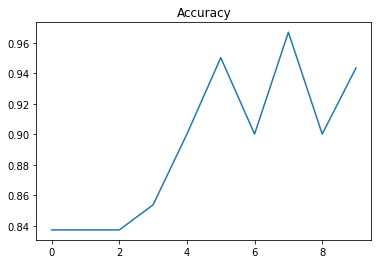

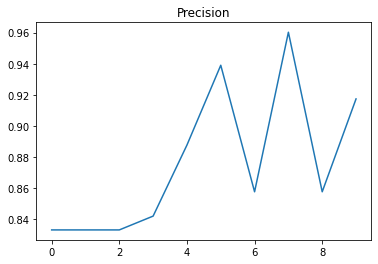

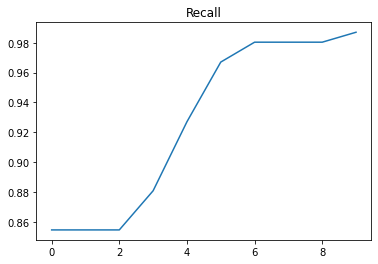

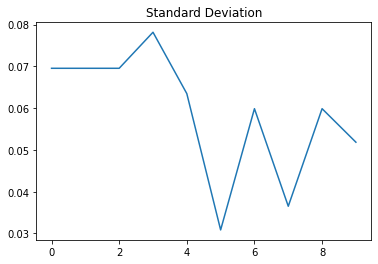

In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()


#Periodogram Features

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 periodogram.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 periodogram.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 periodogram.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 periodogram.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 751)
(302,)


In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,2253),scale_features=False,scale_samples=False)

In [0]:
model = LogisticRegression(max_iter=5000)
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9933333333333334
Precision = 1.0
Recall = 0.9866666666666667
Standard Deviation = 0.019999999999999997
Confusion Matrix:
[[151.   0.]
 [  2. 149.]]


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.4967741935483871
Precision = 0.04838709677419355
Recall = 0.1
Standard Deviation = 0.0064516129032258
Confusion Matrix:
[[135.  16.]
 [136.  15.]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9866666666666667
Precision = 1.0
Recall = 0.9733333333333333
Standard Deviation = 0.02211083193570266
Confusion Matrix:
[[151.   0.]
 [  4. 147.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9703225806451613
Precision = 1.0
Recall = 0.9404166666666667
Standard Deviation = 0.022987627813441415
Confusion Matrix:
[[151.   0.]
 [  9. 142.]]


INITIAL GUESS  7
TRIAL  0
POPULATION: 
 [ 5.  9.  7.  7.  7.  8.  8.  6.  5. 10.]
SCORES:  [0.99010753 0.97698925 0.98688172 0.98688172 0.98688172 0.97698925
 0.97698925 0.98688172 0.99010753 0.97365591]

New Guess:  5.0  Score =  0.9901075268817205
Precision = 1.0
Recall = 0.9800000000000001
Standard Deviation = 0.021228322889037525
Confusion Matrix:
[[151.   0.]
 [  3. 148.]]
TRIAL  1
POPULATION: 
 [6. 7. 6. 6. 3. 3. 6. 4. 5. 5.]
SCORES:  [0.98688172 0.98688172 0.98688172 0.98688172 0.99344086 0.99344086
 0.98688172 0.99010753 0.99010753 0.99010753]

New Guess:  3.0  Score =  0.9934408602150537
Precision = 1.0
Recall = 0.9866666666666667
Standard Deviation = 0.01312048280458157
Confusion Matrix:
[[151.   0.]
 [  2. 149.]]
TRIAL  2
POPULATION: 
 [2. 3. 3. 1. 4. 3. 4. 3. 3. 2.]
SCORES:  [0.99344086 0.99344086 0.99344086 0.99666667 0.99010753 0.99344086
 0.99010753 0.99344086 0.99344086 0.99344086]

New Guess:  2.0  Score =  0.9934408602150537
Precision = 1.0
Recall = 0.9866666666666667

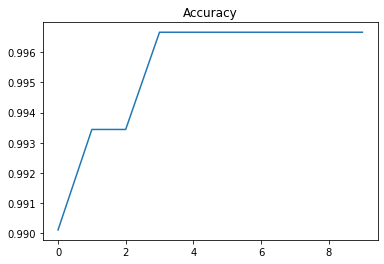

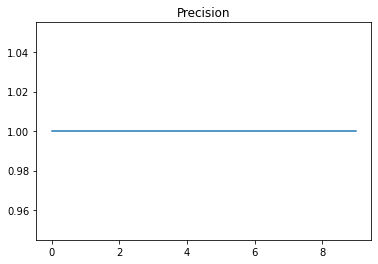

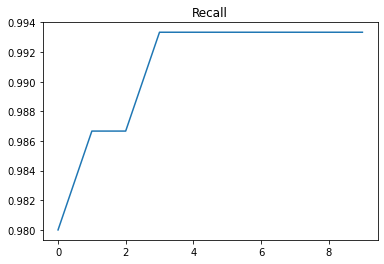

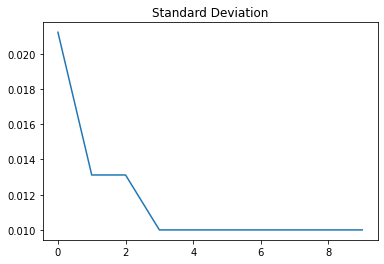

In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

#Energy Features

These features are energy ratios of the total energy above 10Hz to the total energy below 10Hz.

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 energy_ratios.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 energy_ratios.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 energy_ratios.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 energy_ratios.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 3)
(302,)


(151, 3, 3)


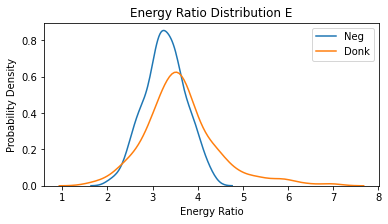

In [0]:
plt.rcParams["figure.figsize"] = (6,3)
neg_ratios = filter(feature_data,target_data,0)
donk_ratios = filter(feature_data,target_data,1)
print(donk_ratios.shape)
sns.distplot(neg_ratios[:,2,2], label='Neg',hist=False,kde=True)
sns.distplot(donk_ratios[:,2,2], label='Donk',hist=False,kde=True)
plt.legend()
plt.xlabel('Energy Ratio')
plt.ylabel('Probability Density')
plt.title('Energy Ratio Distribution E')
plt.savefig('ratios3_e.pdf',format='pdf')

In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,9),False,False)

In [0]:
model = LogisticRegression()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9337634408602151
Precision = 1.0
Recall = 0.8679166666666667
Standard Deviation = 0.03633135871826405
Confusion Matrix:
[[151.   0.]
 [ 20. 131.]]


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.4967741935483871
Precision = 0.04838709677419355
Recall = 0.1
Standard Deviation = 0.0064516129032258
Confusion Matrix:
[[135.  16.]
 [136.  15.]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.986774193548387
Precision = 1.0
Recall = 0.9737500000000001
Standard Deviation = 0.02201571874576672
Confusion Matrix:
[[151.   0.]
 [  4. 147.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9801075268817204
Precision = 1.0
Recall = 0.9604166666666668
Standard Deviation = 0.026614803885642267
Confusion Matrix:
[[151.   0.]
 [  6. 145.]]


INITIAL GUESS  3
TRIAL  0
POPULATION: 
 [2. 3. 4. 1. 4. 2. 5. 3. 1. 5.]
SCORES:  [0.98       0.98333333 0.98       0.98333333 0.98       0.98
 0.98333333 0.98333333 0.98333333 0.98333333]

New Guess:  3.0  Score =  0.9833333333333334
Precision = 1.0
Recall = 0.9666666666666666
Standard Deviation = 0.022360679774997894
Confusion Matrix:
[[151.   0.]
 [  5. 146.]]
TRIAL  1
POPULATION: 
 [4. 3. 4. 1. 4. 4. 2. 2. 4. 4.]
SCORES:  [0.98       0.98333333 0.98       0.98333333 0.98       0.98
 0.98       0.98       0.98       0.98      ]

New Guess:  2.0  Score =  0.9800000000000001
Precision = 1.0
Recall = 0.96
Standard Deviation = 0.022110831935702662
Confusion Matrix:
[[151.   0.]
 [  6. 145.]]
TRIAL  2
POPULATION: 
 [1. 1. 2. 2. 1. 3. 4. 2. 1. 2.]
SCORES:  [0.98333333 0.98333333 0.98       0.98       0.98333333 0.98333333
 0.98       0.98       0.98333333 0.98      ]

New Guess:  1.0  Score =  0.9833333333333334
Precision = 1.0
Recall = 0.9666666666666666
Standard Deviation = 0.02236067977

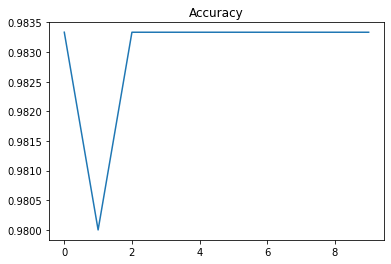

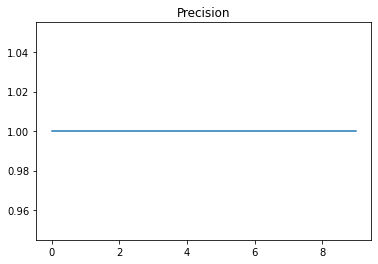

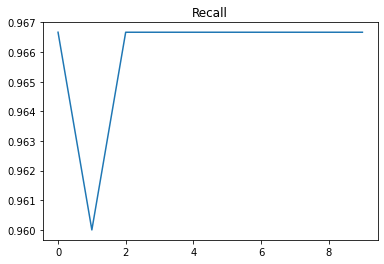

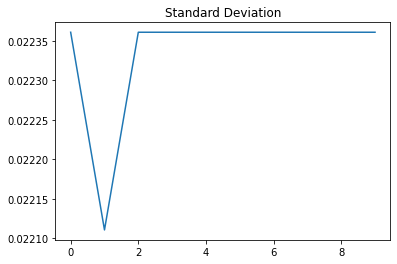

In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

#STFT Features

##Filterbank Coefficients

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 STFT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 STFT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 STFT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 STFT_FC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 45, 16)
(302,)


In [0]:
x = feature_data.reshape(302,2160)

cm = np.sum(abs(np.corrcoef(x.T)))/2160**2
print('stft feature corr =', cm)


stft feature corr = 0.24458671187421005


In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,2160),scale_features=False,scale_samples=False)

In [0]:
model = LogisticRegression(max_iter = 5000)
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.9736559139784946
Precision = 0.9870833333333333
Recall = 0.9604166666666666
Standard Deviation = 0.019540625640200277
Confusion Matrix:
[[149.   2.]
 [  6. 145.]]


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.8974193548387097
Precision = 0.9381526969762264
Recall = 0.8612499999999998
Standard Deviation = 0.04308649245283351
Confusion Matrix:
[[141.  10.]
 [ 21. 130.]]


In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9966666666666667
Precision = 1.0
Recall = 0.9933333333333334
Standard Deviation = 0.009999999999999998
Confusion Matrix:
[[151.   0.]
 [  1. 150.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.9933333333333334
Precision = 1.0
Recall = 0.9866666666666667
Standard Deviation = 0.01333333333333333
Confusion Matrix:
[[151.   0.]
 [  2. 149.]]


INITIAL GUESS  6
TRIAL  0
POPULATION: 
 [9. 8. 8. 7. 5. 8. 1. 6. 6. 8.]
SCORES:  [0.98021505 0.98021505 0.98021505 0.98354839 0.98354839 0.98021505
 0.99021505 0.98354839 0.98354839 0.98021505]

New Guess:  3.0  Score =  0.9868817204301076
Precision = 1.0
Recall = 0.9733333333333334
Standard Deviation = 0.02159551003979905
Confusion Matrix:
[[151.   0.]
 [  4. 147.]]
TRIAL  1
POPULATION: 
 [7. 3. 6. 1. 2. 4. 1. 1. 2. 1.]
SCORES:  [0.98354839 0.98688172 0.98354839 0.99021505 0.98688172 0.98354839
 0.99021505 0.99021505 0.98688172 0.99021505]

New Guess:  1.0  Score =  0.9902150537634409
Precision = 1.0
Recall = 0.9800000000000001
Standard Deviation = 0.02077496158334489
Confusion Matrix:
[[151.   0.]
 [  3. 148.]]
TRIAL  2
POPULATION: 
 [1. 2. 1. 2. 3. 1. 3. 1. 1. 2.]
SCORES:  [0.99021505 0.98688172 0.99021505 0.98688172 0.98688172 0.99021505
 0.98688172 0.99021505 0.99021505 0.98688172]

New Guess:  1  Score =  0.9902150537634409
Precision = 1.0
Recall = 0.9800000000000001
Standard Dev

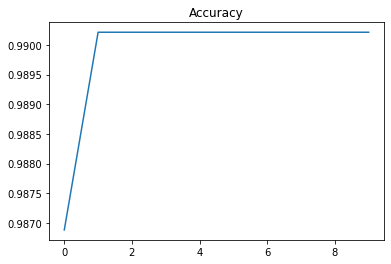

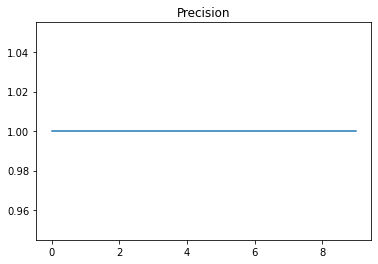

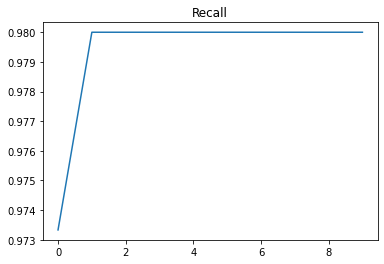

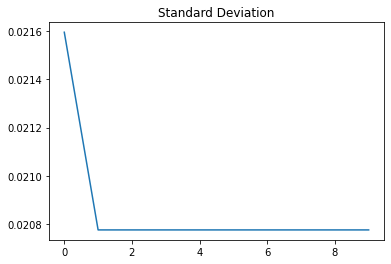

In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

##Cepstral Coefficients

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 STFT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 STFT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 STFT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 STFT_CC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 45, 13)
(302,)


In [0]:
x = feature_data.reshape(302,1755)

cm = np.sum(abs(np.corrcoef(x.T)))/1755**2
print('stft feature corr =', cm)

stft feature corr = 0.07334247927660673


In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,1755),scale_features=False,scale_samples=False)

In [0]:
model = LogisticRegression()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9735483870967743
Precision = 1.0
Recall = 0.9470833333333333
Standard Deviation = 0.029013135876988196
Confusion Matrix:
[[151.   0.]
 [  8. 143.]]


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.8744086021505378
Precision = 0.9790476190476192
Recall = 0.76875
Standard Deviation = 0.031389010392290646
Confusion Matrix:
[[148.   3.]
 [ 35. 116.]]


In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.9966666666666667
Precision = 1.0
Recall = 0.9933333333333334
Standard Deviation = 0.009999999999999998
Confusion Matrix:
[[151.   0.]
 [  1. 150.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9769892473118279
Precision = 0.9928571428571429
Recall = 0.96
Standard Deviation = 0.032767306588801566
Confusion Matrix:
[[150.   1.]
 [  6. 145.]]


INITIAL GUESS  5
TRIAL  0
POPULATION: 
 [5. 8. 5. 5. 6. 3. 8. 7. 4. 6.]
SCORES:  [0.97032258 0.95365591 0.97032258 0.97032258 0.95698925 0.98354839
 0.95365591 0.96032258 0.97032258 0.95698925]

New Guess:  3.0  Score =  0.9835483870967743
Precision = 1.0
Recall = 0.9670833333333334
Standard Deviation = 0.022203975628326517
Confusion Matrix:
[[151.   0.]
 [  5. 146.]]
TRIAL  1
POPULATION: 
 [2. 4. 6. 3. 4. 5. 5. 1. 5. 6.]
SCORES:  [0.97021505 0.97032258 0.95698925 0.98354839 0.97032258 0.97032258
 0.97032258 0.98688172 0.97032258 0.95698925]

New Guess:  1.0  Score =  0.9868817204301076
Precision = 1.0
Recall = 0.9737500000000001
Standard Deviation = 0.021919665390601525
Confusion Matrix:
[[151.   0.]
 [  4. 147.]]
TRIAL  2
POPULATION: 
 [1. 1. 1. 1. 1. 1. 3. 3. 2. 5.]
SCORES:  [0.98688172 0.98688172 0.98688172 0.98688172 0.98688172 0.98688172
 0.98354839 0.98354839 0.97021505 0.97032258]

New Guess:  1  Score =  0.9868817204301076
Precision = 1.0
Recall = 0.9737500000000001
Standard D

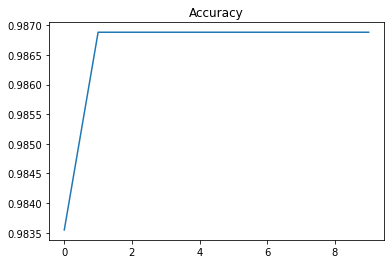

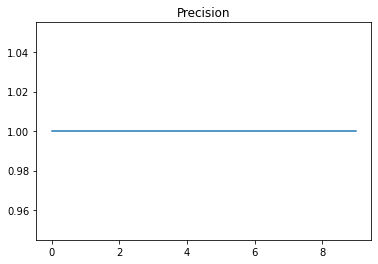

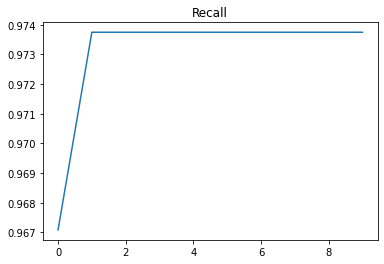

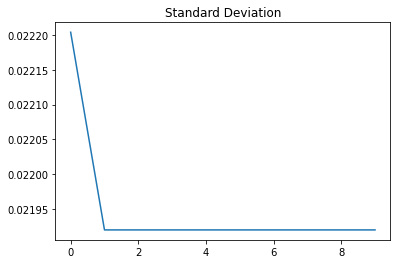

In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

#HHT Features

##Filterbank Coefficients

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 HHT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 HHT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 HHT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 HHT_FC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 1500, 16)
(302,)


In [0]:
x = feature_data.reshape(302,72000)

cm = np.sum(abs(np.corrcoef(x.T)))/72000**2
print('stft feature corr =', cm)

In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,72000),False,False)

In [0]:
model = LogisticRegression()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy = 0.636774193548387
Precision = 0.7364823348694317
Recall = 0.42666666666666664
Standard Deviation = 0.10755032002614826
Confusion Matrix:
[[128.  23.]
 [ 87.  64.]]


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9435483870967742
Precision = 1.0
Recall = 0.8875000000000002
Standard Deviation = 0.03953203542050902
Confusion Matrix:
[[151.   0.]
 [ 17. 134.]]


In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.715483870967742
Precision = 0.6646813674502462
Recall = 0.9004166666666666
Standard Deviation = 0.05014766033170576
Confusion Matrix:
[[ 80.  71.]
 [ 15. 136.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])

Accuracy = 0.9567741935483871
Precision = 1.0
Recall = 0.9133333333333333
Standard Deviation = 0.051769029097374596
Confusion Matrix:
[[151.   0.]
 [ 13. 138.]]


In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

INITIAL GUESS  3
TRIAL  0
POPULATION: 
 [6. 6. 1. 1. 2. 3. 3. 5. 2. 4.]
SCORES:  [0.63215054 0.63215054 0.76150538 0.76150538 0.67860215 0.69516129
 0.69516129 0.66526882 0.67860215 0.66849462]

New Guess:  1.0  Score =  0.761505376344086
Precision = 0.81490675990676
Recall = 0.6754166666666668
Standard Deviation = 0.0927088767634032
Confusion Matrix:
[[128.  23.]
 [ 49. 102.]]
TRIAL  1
POPULATION: 
 [1. 3. 1. 2. 1. 2. 1. 2. 1. 3.]


KeyboardInterrupt: ignored

##Cepstral Coefficients

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/500/Feature Set 79 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/500/Feature Set 98 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/500/Feature Set 194 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/500/Feature Set 195 HHT_CC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 500, 13)
(302,)


In [0]:
x = feature_data.reshape(302,58500)

cm = np.sum(abs(np.corrcoef(x.T)))/58500**2
print('stft feature corr =', cm)

stft feature corr = 0.10194912134989129


In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
x,y = scaling(feature_data,target_data,(302,58500),scale_features=False,scale_samples=False)

In [0]:
model = LogisticRegression()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]
print(false[0].shape)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy = 0.6301075268817204
Precision = 0.7221966205837174
Recall = 0.4333333333333333
Standard Deviation = 0.09316445749637725
Confusion Matrix:
[[125.  26.]
 [ 86.  65.]]
(16, 3, 19500)


In [0]:
model = BernoulliNB()
R = train(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.9336559139784948
Precision = 1.0
Recall = 0.8675
Standard Deviation = 0.04225423386834901
Confusion Matrix:
[[151.   0.]
 [ 20. 131.]]


In [0]:
model = SVC()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.682258064516129
Precision = 0.6313357487922706
Recall = 0.91375
Standard Deviation = 0.06938817236793586
Confusion Matrix:
[[ 68.  83.]
 [ 13. 138.]]


In [0]:
model = RandomForestClassifier()
R = cross_validate_sklearn(10,x,y,model)
print('Accuracy =', R[0])
print('Precision =',R[1])
print('Recall =',R[2])
print('Standard Deviation =',R[3])
print('Confusion Matrix:')
print(R[4])
false = R[5]

Accuracy = 0.966989247311828
Precision = 1.0
Recall = 0.9333333333333333
Standard Deviation = 0.03269612947852747
Confusion Matrix:
[[151.   0.]
 [ 10. 141.]]


In [0]:
sigma = 2
alpha = 5
pop_size = 10
trials = 10
population = np.zeros(shape=(pop_size,))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []


mu = random.randint(1,10)

print('INITIAL GUESS ', mu)

def discretize(population, lim = 1):
  for i,r in enumerate(population):
    population[i] = round(r)
    if r < lim:
      population[i] = lim
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,k in enumerate(population):
    model = KNeighborsClassifier(int(k))
    scores[i] = cross_validate_sklearn(10,x,y,model,serial=False)[0]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  mu = round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if mu < 1:
    mu = 1

  model = KNeighborsClassifier(int(mu))
  R = cross_validate_sklearn(10,x,y,model,False)
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[1])
  learning_curve_recall.append(R[2])
  learning_curve_std.append(R[3])
  print('')
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[1])
  print('Recall =',R[2])
  print('Standard Deviation =',R[3])
  print('Confusion Matrix:')
  print(R[4])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

INITIAL GUESS  3
TRIAL  0
POPULATION: 
 [4. 1. 4. 7. 1. 2. 2. 1. 2. 5.]
SCORES:  [0.62602151 0.74215054 0.62602151 0.60258065 0.74215054 0.65903226
 0.65903226 0.74215054 0.65903226 0.63258065]

New Guess:  1.0  Score =  0.7421505376344085
Precision = 0.8420734820734822
Recall = 0.6033333333333333
Standard Deviation = 0.06743538764278405
Confusion Matrix:
[[133.  18.]
 [ 60.  91.]]
TRIAL  1
POPULATION: 
 [4. 1. 1. 1. 1. 1. 2. 1. 4. 2.]


KeyboardInterrupt: ignored

#CNN




In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 HHT_CC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 1500, 13)
(302,)


In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 HHT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 HHT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 HHT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 HHT_FC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 1500, 16)
(302,)


In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 STFT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 STFT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 STFT_FC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 STFT_FC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 45, 16)
(302,)


In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 STFT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 STFT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 STFT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 STFT_CC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 45, 13)
(302,)


In [0]:
x,y = scaling(feature_data,target_data,(302, 3, 45, 13,1),scale_samples=True,scale_features=False,one_hot=True)

Now, we can create the actual model. A CNN is created using Keras. Since the input is three dimensional, Conv3D and MaxPooling3D layers are used. The first input to each Conv3D layer specifies the number of kernels to be used in the convolution. The second input is a tuple describing the shape of the kernels. Finally, the activation function is defined. reLU is a popular choice of activation since it is piecewise linear so is less computationally complex and it helps with vanishing and exploading gradients in backpropagation. However, the model itself is not very deep and the GPU acceleration helps with time complexity so a more complex tanh activation function is chosen, slightly increasing performance. 

The output of the convolutional netowork is flattened and passed to a standard deep network.

In [0]:
#HHT
def create_model(shape, serial = False):
  model = Sequential()

  model.add(Conv3D(64,(3,3,3),activation='tanh',input_shape=shape))
  model.add(MaxPooling3D((1,3,3)))
  model.add(Conv3D(32,(1,3,2),activation='tanh'))
  model.add(MaxPooling3D((1,3,2)))
  model.add(Conv3D(16,(1,3,1),activation='tanh'))
  model.add(MaxPooling3D((1,3,1)))



  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dense(2, activation='sigmoid'))

  if serial == True:
    model.summary()
  
  return model

In [0]:
#STFT
def create_model(shape, serial = False):
  model = Sequential()


  model.add(Conv3D(128,(3,3,3),activation='tanh',input_shape=shape))
  model.add(MaxPooling3D((1,2,2)))  
  model.add(Conv3D(64,(1,3,3),activation='tanh'))
  model.add(MaxPooling3D((1,2,2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dense(2, activation='sigmoid'))

  if serial == True:
    model.summary()
  
  return model

Callbacks are used to save the model and stop training before overfitting kicks in. Performance is measured by validation loss.

In [0]:
es = EarlyStopping(monitor='val_loss',mode='min',patience=15,restore_best_weights=True)
mcp = ModelCheckpoint('/content/drive/My Drive/FYP/MODELS/HHTCC_CNN.hdf5',monitor='val_loss',save_best_only='True')

In [0]:
model = create_model((x.shape[1],x.shape[2],x.shape[3],x.shape[4]),serial=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 1, 43, 11, 128)    3584      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 21, 5, 128)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 1, 19, 3, 64)      73792     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 9, 1, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               288500    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

The function below is a unique cross validation function to interface with Keras models.

In [0]:
def cross_validate_keras(k,x,y):
  scores = []
  loss = []
  batch_size = 300
  kf = KFold(n_splits=k)
  for train, test in kf.split(x):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    model = create_model((x.shape[1],x.shape[2],x.shape[3],x.shape[4]))
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(x_train,y_train,epochs=100,batch_size=batch_size,validation_split=0.1,callbacks=[es],verbose=1)
    plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
    plt.plot(history.history['accuracy'], label='Accuracy (training data)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    plt.title('Model performance')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    score,acc = model.evaluate(x_test,y_test, batch_size=batch_size)
    print('score = ',acc)
    scores.append(acc)
    loss.append(score)
  print('Cross Validation Score = ',np.mean(scores))
  print('Score Standard Deviation =', np.std(scores))
  print('Binary Cross Validation Loss =', np.mean(loss))

Train on 243 samples, validate on 28 samples
Epoch 1/100
243/243 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5288 - val_loss: 0.7352 - val_accuracy: 0.5714
Epoch 2/100
243/243 [==============================] - 0s 173us/step - loss: 0.6697 - accuracy: 0.6872 - val_loss: 0.6160 - val_accuracy: 0.6786
Epoch 3/100
243/243 [==============================] - 0s 165us/step - loss: 0.5717 - accuracy: 0.7284 - val_loss: 0.5427 - val_accuracy: 0.8393
Epoch 4/100
243/243 [==============================] - 0s 166us/step - loss: 0.5181 - accuracy: 0.8889 - val_loss: 0.4684 - val_accuracy: 0.9107
Epoch 5/100
243/243 [==============================] - 0s 165us/step - loss: 0.4305 - accuracy: 0.9650 - val_loss: 0.4118 - val_accuracy: 0.8393
Epoch 6/100
243/243 [==============================] - 0s 160us/step - loss: 0.3426 - accuracy: 0.9362 - val_loss: 0.3538 - val_accuracy: 0.8571
Epoch 7/100
243/243 [==============================] - 0s 162us/step - loss: 0.2677 - a

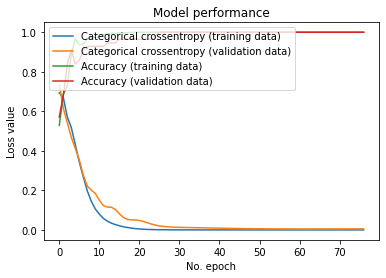

31/31 [==============================] - 0s 2ms/step
score =  0.9677419066429138
Train on 243 samples, validate on 28 samples
Epoch 1/100
243/243 [==============================] - 0s 816us/step - loss: 0.6877 - accuracy: 0.5802 - val_loss: 0.6729 - val_accuracy: 0.5000
Epoch 2/100
243/243 [==============================] - 0s 163us/step - loss: 0.6313 - accuracy: 0.5802 - val_loss: 0.5771 - val_accuracy: 0.8571
Epoch 3/100
243/243 [==============================] - 0s 157us/step - loss: 0.5544 - accuracy: 0.9465 - val_loss: 0.4974 - val_accuracy: 0.9286
Epoch 4/100
243/243 [==============================] - 0s 155us/step - loss: 0.4766 - accuracy: 0.9691 - val_loss: 0.4249 - val_accuracy: 0.8571
Epoch 5/100
243/243 [==============================] - 0s 157us/step - loss: 0.3816 - accuracy: 0.9465 - val_loss: 0.3479 - val_accuracy: 0.8750
Epoch 6/100
243/243 [==============================] - 0s 160us/step - loss: 0.2974 - accuracy: 0.9527 - val_loss: 0.2614 - val_accuracy: 0.9643
Epoc

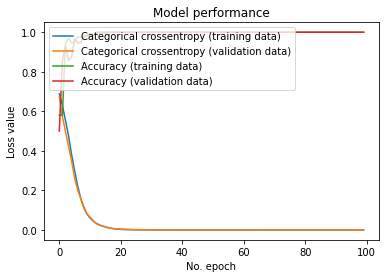

31/31 [==============================] - 0s 218us/step
score =  0.9677419066429138
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 1s 2ms/step - loss: 0.6999 - accuracy: 0.4652 - val_loss: 0.6588 - val_accuracy: 0.5179
Epoch 2/100
244/244 [==============================] - 0s 175us/step - loss: 0.6367 - accuracy: 0.5164 - val_loss: 0.5854 - val_accuracy: 0.7857
Epoch 3/100
244/244 [==============================] - 0s 169us/step - loss: 0.5532 - accuracy: 0.8791 - val_loss: 0.5044 - val_accuracy: 0.8929
Epoch 4/100
244/244 [==============================] - 0s 170us/step - loss: 0.4704 - accuracy: 0.9406 - val_loss: 0.4034 - val_accuracy: 0.9286
Epoch 5/100
244/244 [==============================] - 0s 184us/step - loss: 0.3691 - accuracy: 0.9713 - val_loss: 0.3175 - val_accuracy: 0.9107
Epoch 6/100
244/244 [==============================] - 0s 166us/step - loss: 0.2775 - accuracy: 0.9631 - val_loss: 0.2327 - val_accuracy: 0.9464
Epoc

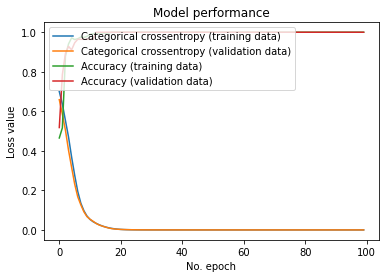

30/30 [==============================] - 0s 2ms/step
score =  1.0
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5266 - val_loss: 0.7230 - val_accuracy: 0.6071
Epoch 2/100
244/244 [==============================] - 0s 161us/step - loss: 0.6845 - accuracy: 0.6250 - val_loss: 0.5896 - val_accuracy: 0.8929
Epoch 3/100
244/244 [==============================] - 0s 157us/step - loss: 0.5719 - accuracy: 0.9180 - val_loss: 0.5315 - val_accuracy: 0.7500
Epoch 4/100
244/244 [==============================] - 0s 156us/step - loss: 0.5190 - accuracy: 0.8074 - val_loss: 0.4453 - val_accuracy: 0.9286
Epoch 5/100
244/244 [==============================] - 0s 162us/step - loss: 0.4184 - accuracy: 0.9590 - val_loss: 0.3649 - val_accuracy: 0.9107
Epoch 6/100
244/244 [==============================] - 0s 171us/step - loss: 0.3264 - accuracy: 0.9631 - val_loss: 0.2826 - val_accuracy: 0.9643
Epoch 7/100
244/244 [

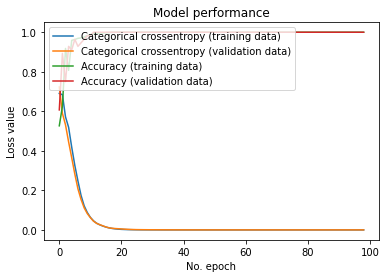

30/30 [==============================] - 0s 179us/step
score =  1.0
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 992us/step - loss: 0.6931 - accuracy: 0.5328 - val_loss: 0.6557 - val_accuracy: 0.6429
Epoch 2/100
244/244 [==============================] - 0s 158us/step - loss: 0.6282 - accuracy: 0.6844 - val_loss: 0.5558 - val_accuracy: 0.8571
Epoch 3/100
244/244 [==============================] - 0s 155us/step - loss: 0.5399 - accuracy: 0.9221 - val_loss: 0.4715 - val_accuracy: 0.8929
Epoch 4/100
244/244 [==============================] - 0s 156us/step - loss: 0.4515 - accuracy: 0.9467 - val_loss: 0.3833 - val_accuracy: 0.9286
Epoch 5/100
244/244 [==============================] - 0s 155us/step - loss: 0.3509 - accuracy: 0.9652 - val_loss: 0.3027 - val_accuracy: 0.9286
Epoch 6/100
244/244 [==============================] - 0s 164us/step - loss: 0.2649 - accuracy: 0.9734 - val_loss: 0.2351 - val_accuracy: 0.9286
Epoch 7/100
244/2

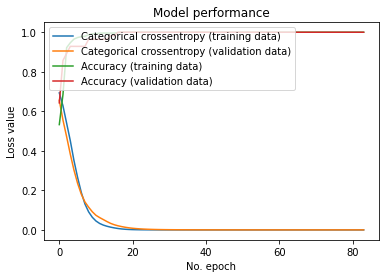

30/30 [==============================] - 0s 218us/step
score =  0.9333333373069763
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 997us/step - loss: 0.6838 - accuracy: 0.5266 - val_loss: 0.6226 - val_accuracy: 0.6607
Epoch 2/100
244/244 [==============================] - 0s 158us/step - loss: 0.6055 - accuracy: 0.7152 - val_loss: 0.5277 - val_accuracy: 0.8929
Epoch 3/100
244/244 [==============================] - 0s 157us/step - loss: 0.5163 - accuracy: 0.9426 - val_loss: 0.4335 - val_accuracy: 0.9286
Epoch 4/100
244/244 [==============================] - 0s 171us/step - loss: 0.4200 - accuracy: 0.9631 - val_loss: 0.3438 - val_accuracy: 0.9286
Epoch 5/100
244/244 [==============================] - 0s 159us/step - loss: 0.3192 - accuracy: 0.9549 - val_loss: 0.2583 - val_accuracy: 0.9643
Epoch 6/100
244/244 [==============================] - 0s 159us/step - loss: 0.2339 - accuracy: 0.9754 - val_loss: 0.1935 - val_accuracy: 0.9643
Ep

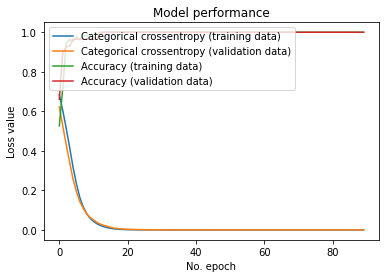

30/30 [==============================] - 0s 151us/step
score =  1.0
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 932us/step - loss: 0.6928 - accuracy: 0.5184 - val_loss: 0.6693 - val_accuracy: 0.4286
Epoch 2/100
244/244 [==============================] - 0s 156us/step - loss: 0.6215 - accuracy: 0.5225 - val_loss: 0.5652 - val_accuracy: 0.8929
Epoch 3/100
244/244 [==============================] - 0s 157us/step - loss: 0.5494 - accuracy: 0.9529 - val_loss: 0.4788 - val_accuracy: 0.8929
Epoch 4/100
244/244 [==============================] - 0s 153us/step - loss: 0.4566 - accuracy: 0.9508 - val_loss: 0.4091 - val_accuracy: 0.8393
Epoch 5/100
244/244 [==============================] - 0s 160us/step - loss: 0.3644 - accuracy: 0.9180 - val_loss: 0.3136 - val_accuracy: 0.8750
Epoch 6/100
244/244 [==============================] - 0s 159us/step - loss: 0.2745 - accuracy: 0.9467 - val_loss: 0.2380 - val_accuracy: 0.9107
Epoch 7/100
244/2

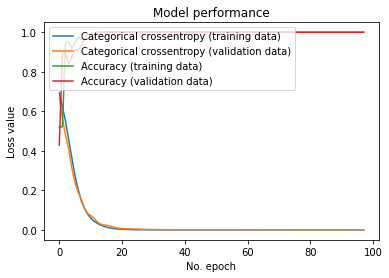

30/30 [==============================] - 0s 223us/step
score =  0.9666666388511658
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 906us/step - loss: 0.7011 - accuracy: 0.4816 - val_loss: 0.6727 - val_accuracy: 0.4464
Epoch 2/100
244/244 [==============================] - 0s 155us/step - loss: 0.6466 - accuracy: 0.5123 - val_loss: 0.6111 - val_accuracy: 0.7321
Epoch 3/100
244/244 [==============================] - 0s 159us/step - loss: 0.5892 - accuracy: 0.7828 - val_loss: 0.5340 - val_accuracy: 0.9643
Epoch 4/100
244/244 [==============================] - 0s 153us/step - loss: 0.5229 - accuracy: 0.9775 - val_loss: 0.4627 - val_accuracy: 0.8571
Epoch 5/100
244/244 [==============================] - 0s 158us/step - loss: 0.4372 - accuracy: 0.9549 - val_loss: 0.3846 - val_accuracy: 0.8750
Epoch 6/100
244/244 [==============================] - 0s 155us/step - loss: 0.3514 - accuracy: 0.9549 - val_loss: 0.2927 - val_accuracy: 0.9643
Ep

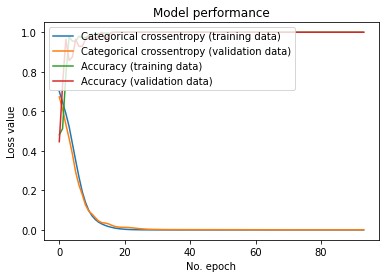

30/30 [==============================] - 0s 307us/step
score =  1.0
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 884us/step - loss: 0.7049 - accuracy: 0.5000 - val_loss: 0.7234 - val_accuracy: 0.5000
Epoch 2/100
244/244 [==============================] - 0s 160us/step - loss: 0.6900 - accuracy: 0.5000 - val_loss: 0.6247 - val_accuracy: 0.5893
Epoch 3/100
244/244 [==============================] - 0s 155us/step - loss: 0.5934 - accuracy: 0.6311 - val_loss: 0.5636 - val_accuracy: 0.7857
Epoch 4/100
244/244 [==============================] - 0s 153us/step - loss: 0.5447 - accuracy: 0.7951 - val_loss: 0.4898 - val_accuracy: 0.9286
Epoch 5/100
244/244 [==============================] - 0s 154us/step - loss: 0.4694 - accuracy: 0.9242 - val_loss: 0.4113 - val_accuracy: 0.9286
Epoch 6/100
244/244 [==============================] - 0s 157us/step - loss: 0.3777 - accuracy: 0.9631 - val_loss: 0.3459 - val_accuracy: 0.9286
Epoch 7/100
244/2

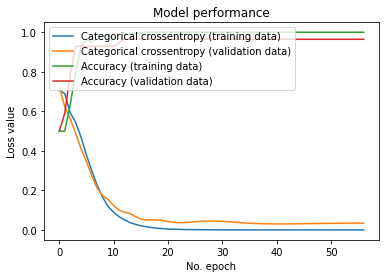

30/30 [==============================] - 0s 198us/step
score =  0.9666666388511658
Train on 244 samples, validate on 28 samples
Epoch 1/100
244/244 [==============================] - 0s 888us/step - loss: 0.7043 - accuracy: 0.4283 - val_loss: 0.6683 - val_accuracy: 0.5000
Epoch 2/100
244/244 [==============================] - 0s 160us/step - loss: 0.6477 - accuracy: 0.5102 - val_loss: 0.6096 - val_accuracy: 0.8393
Epoch 3/100
244/244 [==============================] - 0s 159us/step - loss: 0.5762 - accuracy: 0.9139 - val_loss: 0.5618 - val_accuracy: 0.8571
Epoch 4/100
244/244 [==============================] - 0s 157us/step - loss: 0.5107 - accuracy: 0.9549 - val_loss: 0.4918 - val_accuracy: 0.9107
Epoch 5/100
244/244 [==============================] - 0s 159us/step - loss: 0.4198 - accuracy: 0.9385 - val_loss: 0.4312 - val_accuracy: 0.9107
Epoch 6/100
244/244 [==============================] - 0s 157us/step - loss: 0.3412 - accuracy: 0.9201 - val_loss: 0.3530 - val_accuracy: 0.9286
Ep

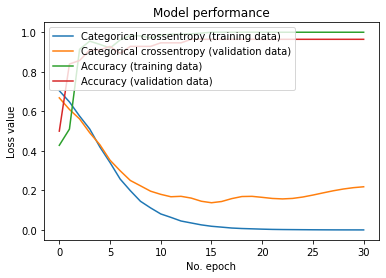

30/30 [==============================] - 0s 208us/step
score =  0.9666666388511658
Cross Validation Score =  0.9768817067146301
Score Standard Deviation = 0.021247110723216996
Binary Cross Validation Loss = 0.039588275954429264


In [0]:
cross_validate_keras(10,x,y)

In [0]:
model = create_model((x.shape[1],x.shape[2],x.shape[3],x.shape[4]),serial=True)
model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x,y,epochs=100,batch_size=300,validation_split = 0.1,callbacks=[es,mcp],verbose=1)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_64 (Conv3D)           (None, 1, 498, 11, 64)    1792      
_________________________________________________________________
max_pooling3d_64 (MaxPooling (None, 1, 166, 3, 64)     0         
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 1, 164, 2, 32)     12320     
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 1, 54, 1, 32)      0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 1, 52, 1, 16)      1552      
_________________________________________________________________
max_pooling3d_66 (MaxPooling (None, 1, 17, 1, 16)      0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 272)             

#HMM

The Hidden Markov Model (HMM) is another popular technique for feature identification of seismic signals. For this to work, a separate model is trained for each feature. When testing, each set is passed through both models and is classified by whichever model gives the highest state probability. Therefore, feature sets for the different targets are obtained using the 'filter' function.

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 HHT_CC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape)

(302, 3, 1500, 13)
(302,)


In [0]:
x,y = shuffle(feature_data,target_data)

In [0]:
def filter(feature_data, target_data, target):
  res = []
  for i,dat in enumerate(target_data):
    if dat == target:
      res.append(feature_data[i])
  return np.array(res)

The HMM can't take a 3D input, just like the previous traditional models so the split function breaks the input into 2D as well as returning the length of each sample.

In [0]:
def split(data, test = False):
  res = []
  lens = []
  for i,s in enumerate(data):
    z = s[0]
    n = s[1]
    e = s[2]
    x = np.concatenate((z,n,e),axis=1)
    x = preprocessing.scale(x)
    res.append(x)
    lens.append(len(x))
  res = np.array(res)
  lens = np.array(lens)
  if test == False:
    res = np.concatenate([ar for ar in res])
  return res,lens



The evaluate function gets a score for the model performance. The HMM from hmmlearn is actually an unsupervised method, so this extra function transforms it into a supervised method.

In [0]:
def evaluate(models,data,target): 
  score = 0
  true_pos = 0 
  true_neg = 0
  false_pos = 0
  false_neg = 0
  z = [[0 for i in range(len(models))] for j in range(len(data))]
  for i,d in enumerate(data):
    for j,m in enumerate(models):
      z[i][j] = m.score(d)
  z = [z[i].index(max(z[i])) for i in range(len(z))]

  for i,r in enumerate(z):
    if r == target[i]:
      score += 1
  conf_matrix = confusion_matrix(target, z)
  precision = precision_score(target, z,average='binary')
  recall = recall_score(target, z,average='binary')
  acc = score/len(target)

  return acc, conf_matrix, precision,recall


In [0]:
def cross_validate_hmm(k,x,y,donk_state,neg_state,serial=True):
  scores = []
  conf_matrix = np.zeros(shape=(2,2))
  precision = []
  recall = []
  kf = StratifiedKFold(n_splits=k)
  for train, test in kf.split(x,y):
    x_train, x_test = x[train], x[test]
    y_train, y_test = y[train], y[test]

    if serial==True:
      print('NEW FOLD')

    donk_train = filter(x_train,y_train,1)
    neg_train = filter(x_train,y_train,0)

    donk_input = split(donk_train)[0]
    donk_len = split(donk_train)[1]

    neg_input = split(neg_train)[0]
    neg_len = split(neg_train)[1]

    if serial == True:
      print('finished splitting data')

    model_donk = hmm.GaussianHMM(n_components = donk_state, covariance_type="diag")
    model_donk.fit(donk_input,donk_len)
    if serial==True:
      print('Trained Donk Model')
    model_neg = hmm.GaussianHMM(n_components = neg_state, covariance_type="diag")
    model_neg.fit(neg_input,neg_len)
    if serial == True:
      print('Trained Neg Model')
    
    num_features = x_train[0][0].shape[1]
    n_donk = ((num_features+num_features) * donk_state) + (donk_state*donk_state) + donk_state
    n_neg = ((num_features+num_features) * neg_state) + (neg_state*neg_state) + neg_state
    if serial==True:
      print('Number of trainable parameters =', [n_donk,n_neg])

    x_score = split(x_test,True)[0]
    R = evaluate([model_neg,model_donk],x_score,y_test)
    scores.append(R[0])
    conf_matrix += R[1]
    precision.append(R[2])
    recall.append(R[3])
  
  return np.mean(scores),conf_matrix,np.mean(precision),np.mean(recall),np.std(scores)




In [0]:
sigma = 1.5
alpha = 5
pop_size = 10
trials = 20
population = np.zeros(shape=(pop_size,2))
learning_curve_acc = []
learning_curve_precision = []
learning_curve_recall = []
learning_curve_std = []
scores_dict = {}

donk_state = random.randint(2,20)
neg_state = random.randint(2,20)
mu = np.array([donk_state,neg_state])

print('INITIAL GUESS ', mu)

def discretize(population):
  for i,r in enumerate(population):
    population[i] = np.array([round(r[0]), round(r[1])])
    if np.any(r < 2):
      population[i][np.where(r<2)] = 2
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,2)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for j,r in enumerate(population):
    if (r[0],r[1]) not in scores_dict:
      R = cross_validation(10,x,y,int(r[0]),int(r[1]),serial=False)
      scores_dict[(r[0],r[1])] = R
    else:
      R = scores_dict[(r[0],r[1])]

    scores[j] = R[0]

  with open('score_dict.pickle', 'wb') as handle:
    pickle.dump(scores_dict, handle)
  print('SCORES: ', scores)


  A = preprocessing.scale(scores)
  mu = np.round(mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A))
  if np.any(mu < 2):
    mu[np.where(mu < 2)] = 2

  if (mu[0],mu[1]) in scores_dict:
    R = scores_dict[(r[0],r[1])]
  else:
    R = cross_validation(10,x,y,int(mu[0]),int(mu[1]),serial=False)
    scores_dict[(mu[0],mu[1])] = R
  learning_curve_acc.append(R[0])
  learning_curve_precision.append(R[2])
  learning_curve_recall.append(R[3])
  learning_curve_std.append(R[4])
  print('New Guess: ', mu, ' Score = ',R[0])
  print('Precision =',R[2])
  print('Recall =',R[3])
  print('Standard Deviation =',R[4])
  print('Confusion Matrix:')
  print(R[1])
  if int(R[0]) == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve_acc)
plt.title('Accuracy')
plt.show()
plt.plot(learning_curve_precision)
plt.title('Precision')
plt.show()
plt.plot(learning_curve_recall)
plt.title('Recall')
plt.show()
plt.plot(learning_curve_std)
plt.title('Standard Deviation')
plt.show()

INITIAL GUESS  [12 13]
TRIAL  0
POPULATION: 
 [[13. 10.]
 [12. 11.]
 [12. 15.]
 [12. 12.]
 [13. 13.]
 [12. 10.]
 [11. 13.]
 [14. 13.]
 [13. 12.]
 [12. 12.]]


NameError: ignored

In [0]:
sigma = 1.5
alpha = 5
pop_size = 10
trials = 20
population = np.zeros(shape=(pop_size,2))

learning_curve=[]
scores_dict = {}

feature_data,target_data = shuffle(feature_data,target_data)
x_train,x_test,y_train,y_test = train_test_split(feature_data,target_data,test_size = 0.2)
donk_train = filter(x_train,y_train,1)
neg_train = filter(x_train,y_train,0)

donk_input = split(donk_train)[0]
donk_len = split(donk_train)[1]

neg_input = split(neg_train)[0]
neg_len = split(neg_train)[1]

x_score = split(x_test,True)[0]

donk_state = random.randint(2,20)
neg_state = random.randint(2,20)
mu = np.array([donk_state,neg_state])

print('INITIAL GUESS ', mu)

def discretize(population):
  for i,r in enumerate(population):
    population[i] = np.array([round(r[0]), round(r[1])])
    if np.any(r < 2):
      population[i][np.where(r<2)] = 2
  return population

for i in range(trials):
  print('TRIAL ',i)
  normal_dist = np.random.randn(pop_size,2)
  population = mu + sigma*normal_dist
  population = discretize(population)
  print('POPULATION: \n', population)
  scores = np.zeros(shape=(pop_size))

  for i,r in enumerate(population):
    if (r[0],r[1]) in scores_dict:
      scores[i] = scores_dict[(r[0],r[1])]
    else:
      model_donk = hmm.GaussianHMM(n_components = int(r[0]), covariance_type="diag")
      model_donk.fit(donk_input,donk_len)
      model_neg = hmm.GaussianHMM(n_components = int(r[1]), covariance_type="diag")
      model_neg.fit(neg_input,neg_len)
      scores[i], conf_matrix,precision,recall = evaluate([model_neg,model_donk],x_score,y_test)
      scores_dict[(r[0],r[1])] = scores[i]
  print('SCORES: ', scores)

  A = preprocessing.scale(scores)
  print('Weighted scores: ', A)
  print('Unscaled Change: ', np.dot(normal_dist.T,A))
  mu = mu + alpha/(pop_size*sigma) * np.dot(normal_dist.T,A)
  mu = np.array([round(mu[0]),round(mu[1])])
  if np.any(mu < 2):
    mu[np.where(mu < 2)] = 2

  model_donk = hmm.GaussianHMM(n_components = int(mu[0]), covariance_type="diag")
  model_donk.fit(donk_input,donk_len)

  model_neg = hmm.GaussianHMM(n_components = int(mu[1]), covariance_type="diag")
  model_neg.fit(neg_input,neg_len)

  s, conf_matrix, precision, recall = evaluate([model_neg,model_donk],x_score,y_test)
  learning_curve.append(s)
  print('')
  print('New Guess: ', mu, ' Score = ',s)
  print('Precision =', precision)
  print('Recall =', recall)
  if s == 1:
    print('Perfect classification achieved')
    break

plt.plot(learning_curve)
plt.show()

INITIAL GUESS  [7 9]
TRIAL  0
POPULATION: 
 [[ 8.  8.]
 [ 9. 10.]
 [ 7.  9.]
 [ 7. 11.]
 [10. 11.]
 [ 7. 11.]
 [ 7.  9.]
 [ 9. 10.]
 [ 6. 10.]
 [ 6. 10.]]
SCORES:  [0.93442623 0.91803279 0.91803279 0.91803279 0.93442623 0.91803279
 0.91803279 0.91803279 0.91803279 0.91803279]
Weighted scores:  [ 2.  -0.5 -0.5 -0.5  2.  -0.5 -0.5 -0.5 -0.5 -0.5]
Unscaled Change:  [ 5.00828255 -1.3312849 ]

New Guess:  [9. 9.]  Score =  0.9180327868852459
Precision = 0.9375
Recall = 0.9090909090909091
TRIAL  1
POPULATION: 
 [[ 6. 12.]
 [10.  9.]
 [ 7.  7.]
 [10. 11.]
 [ 7. 11.]
 [ 8. 11.]
 [ 9. 11.]
 [ 7. 10.]
 [10.  8.]
 [ 9. 10.]]


KeyboardInterrupt: ignored

In [0]:
s = []
s_d = []
s_n = []
s_std = []
s_mss = []
for i in range(2,26):
  #feature_data,target_data = shuffle(feature_data,target_data)
  print(i)
  acc,conf_matrix,precision,recall,std = cross_validate_hmm(10,x,y,i,i)
  print('Cross Validation Score =',acc)
  print('Precision =', precision)
  print('Recall =',recall)
  print('Standard Deviation =',std)
  print('Confusion Matrix:')
  print(conf_matrix, '\n')
  s.append(acc)
  s_d.append(conf_matrix)
  s_n.append(recall)
  s_std.append(std)
  s_mss.append(precision)

2
NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [70, 70]
Cross Validation Score = 0.9205376344086021
Precision = 0.9875
Recall = 0.85375
Standard Deviation = 0.04261769323440176
Confusion Matrix:
[[149.   2.]
 [ 22. 129.]] 

3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [108, 108]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Cross Validation Score = 0.9538709677419355
Precision = 0.9757352941176471
Recall = 0.9337500000000001
Standard Deviation = 0.02114455365765454
Confusion Matrix:
[[147.   4.]
 [ 10. 141.]] 

4
NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [148, 148]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Cross Validation Score = 0.953763440860215
Precision = 0.99375
Recall = 0.9137500000000001
Standard Deviation = 0.030279844817911232
Confusion Matrix:
[[150.   1.]
 [ 13. 138.]] 

5
NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [190, 190]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Cross Validation Score = 0.9505376344086022
Precision = 0.9715686274509803
Recall = 0.9337500000000001
Standard Deviation = 0.03930250942472487
Confusion Matrix:
[[146.   5.]
 [ 10. 141.]] 

6
NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [234, 234]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Cross Validation Score = 0.9670967741935484
Precision = 0.9819852941176471
Recall = 0.95375
Standard Deviation = 0.02910067605306256
Confusion Matrix:
[[148.   3.]
 [  7. 144.]] 

7
NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [280, 280]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Cross Validation Score = 0.9770967741935485
Precision = 0.9882352941176471
Recall = 0.9670833333333334
Standard Deviation = 0.029143752457752678
Confusion Matrix:
[[149.   2.]
 [  5. 146.]] 

8
NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [328, 328]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [328, 328]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [328, 328]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data
Trained Donk Model
Trained Neg Model
Number of trainable parameters = [328, 328]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


NEW FOLD


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the 

finished splitting data


In [0]:
donk_train = filter(x,y,1)
neg_train = filter(x,y,0)

donk_input = split(donk_train)[0]
donk_len = split(donk_train)[1]

neg_input = split(neg_train)[0]
neg_len = split(neg_train)[1]

print(donk_input.shape)
print(neg_input.shape)

model_donk = hmm.GaussianHMM(n_components = 6, covariance_type="diag")
model_donk.fit(donk_input,donk_len)
model_neg = hmm.GaussianHMM(n_components = 6, covariance_type="diag")
model_neg.fit(neg_input,neg_len)

(226500, 39)
(226500, 39)


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

(1500, 39)
(1500,)


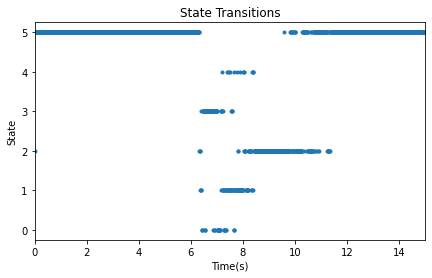

[0.01232089 0.05343578 0.29172642 0.03945677 0.05028791 0.55277224]
[[6.83754560e-001 7.16591520e-002 1.94006262e-045 2.38764189e-001
  5.82209842e-003 2.23781603e-181]
 [2.07377636e-002 7.23830716e-001 4.84457832e-002 2.50319724e-002
  1.81953765e-001 2.96593422e-086]
 [2.42003882e-044 9.76392530e-003 9.18830288e-001 2.31024010e-067
  9.08735576e-003 6.23184306e-002]
 [6.93024086e-002 3.81100625e-002 2.86608722e-068 8.79543359e-001
  1.30441695e-002 1.86989909e-219]
 [1.07059041e-003 1.89356087e-001 5.78802880e-002 9.41458196e-003
  7.42278452e-001 7.98102836e-084]
 [1.10977325e-180 2.78171634e-089 3.28886497e-002 6.99154469e-207
  4.73554818e-104 9.67111350e-001]]
[0.17326791 0.13977131 0.133708   0.35019052 0.09903384 0.10402843]
[[0.54588707 0.06839914 0.08889605 0.09403312 0.10755913 0.09522549]
 [0.0761648  0.5150897  0.16376715 0.08489808 0.06360408 0.09647619]
 [0.12005517 0.19397414 0.46927397 0.05292918 0.09071737 0.07305016]
 [0.04533846 0.02297039 0.02434334 0.86634913 0.02

In [0]:
print(donk_input[:1500].shape)
states_donk = model_donk.predict(donk_input[:1500])
states_neg = model_donk.predict(neg_input[:1500])
print(states_donk.shape)
t = np.arange(1500)/100
plt.rcParams["figure.figsize"] = (7,4)
plt.scatter(t,states_donk,marker='.')
plt.xlabel('Time(s)')
plt.xlim(0,15)
plt.ylabel('State')
plt.title('State Transitions')
plt.show()
print(model_donk.get_stationary_distribution())
print(model_donk.transmat_)
print(model_neg.get_stationary_distribution())
print(model_neg.transmat_)

In [0]:
with open("/content/drive/My Drive/FYP/MODELS/1500/HMM Models/DonkHMM_6.pkl", "wb") as file: pickle.dump(model_donk, file)
with open("/content/drive/My Drive/FYP/MODELS/1500/HMM Models/NegHMM_6.pkl", "wb") as file: pickle.dump(model_neg, file)

#Donk Generator

In [0]:
paths_feature = ['/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 79 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 98 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 194 HHT_CC.npy','/content/drive/My Drive/FYP/FYPdata/Feature/1500/Feature Set 195 HHT_CC.npy']
paths_target = ['/content/drive/My Drive/FYP/FYPdata/Target/Target 79.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 98.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 194.npy','/content/drive/My Drive/FYP/FYPdata/Target/Target 195.npy']
feature_data = load(paths_feature)
print(feature_data.shape)
target_data = load(paths_target)
print(target_data.shape) 

(302, 3, 1500, 13)
(302,)


In [0]:
def plot_mfcc(mfcc):
  t = np.arange(mfcc.shape[0])/100
  mel = np.arange(mfcc.shape[1])
  mfcc = mfcc.T
  cmap = plt.pcolormesh(t, mel, mfcc, cmap = 'jet')
  plt.colorbar(cmap)
  plt.title('HHT Filterbank Spectrogram')
  plt.xlabel('Time [s]')
  plt.ylabel('Coefficient')
  plt.savefig('donk_generator.pdf',format='pdf')
  plt.show()

(151, 58500)


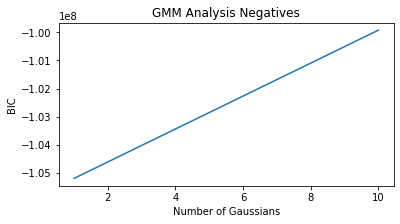

In [0]:
plt.rcParams["figure.figsize"] = (6,3)
n_components = np.arange(1, 11)
donks = filter(feature_data,target_data,0)
donk_features = donks.reshape(151,58500)
print(donk_features.shape)
models = [GaussianMixture(n, covariance_type='diag').fit(donk_features)
          for n in n_components]

plt.plot(n_components, [m.bic(donk_features) for m in models])
plt.title('GMM Analysis Negatives')
plt.xlabel('Number of Gaussians')
plt.ylabel('BIC')
plt.savefig('GMM1500_neg.pdf',format='pdf')


In [0]:
model = hmm.GaussianHMM(n_components=6,covariance_type='diag')
donks = filter(feature_data,target_data,1)
donk_features,lens = split(donks)
print(donk_features.shape)
print(lens)

(226500, 39)
[1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500
 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500 1500]


In [0]:
model.fit(donk_features,lens)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=6, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

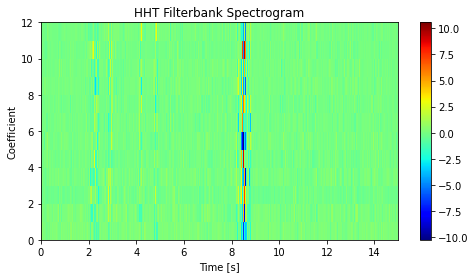

In [0]:
#for i in range(3):
plt.rcParams["figure.figsize"] = (8,4)
#new_data = model.sample(1500)
#new_feature = new_data[0]
#print(new_feature.shape)
plot_mfcc(new_feature[:,:13])